# 05__divergent
# analyzing divergent sequences: conservation and directionality preferences

in this notebook, i analyze two properties of divergent sequences: (1) their conservation (using phylop 46-way placental mammal alignments) and (2) their "directionality preference". by that i mean whether or not they are more likely to activate transcription in the sense direction vs. the antisense direction.

------

no figures in this notebook

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time

from itertools import chain
from decimal import Decimal
from scipy import stats
from scipy import signal
from statsmodels.sandbox.stats import multicomp

# import utils
sys.path.append("../../utils")
from plotting_utils import *
from misc_utils import *
from norm_utils import *

%matplotlib inline

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

## functions

In [3]:
def padj_in_one(row):
    if not pd.isnull(row["hepg2_sig"]):
        if not pd.isnull(row["hepg2_sig"]):
            return True
    elif not pd.isnull(row["hela_sig"]):
        if not pd.isnull(row["hela_sig"]):
            return True
    elif not pd.isnull(row["k562_sig"]):
        if not pd.isnull(row["k562_sig"]):
            return True
    else:
        return False

In [4]:
def sig_in_one(row):
    if row["hepg2_sig"] == "sig" or row["k562_sig"] == "sig" or row["hela_sig"] == "sig":
        return True
    else:
        return False

## variables

In [5]:
biotypes = ["div_lnc", "div_pc", "enhancerMid", "intergenic", "protein_coding"]

In [6]:
# note - this file will have to be changed if re-running outside of harvard odyssey as it's not in the git (large)
bw_f = "/n/rinn_data2/users/kaia/bigwig/all_chr.phyloP46way.placental.bw"

In [7]:
index_dir = "../../data/00__index"
index_f = "%s/tss_oligo_pool.index.txt" % index_dir

In [8]:
hepg2_activ_f = "../../data/02__activs/POOL1__pMPRA1__HepG2__activities_per_barcode.txt"
hela_activ_f = "../../data/02__activs/POOL1__pMPRA1__HeLa__activities_per_barcode.txt"
k562_activ_f = "../../data/02__activs/POOL1__pMPRA1__K562__activities_per_barcode.txt"

In [9]:
annot_f = "../../misc/00__tss_properties/mpra_id_to_biotype_map.txt"

# conservation

## 1. find phyloP scores for TSS +/- 1000

In [10]:
in_path = "../../data/00__index/0__all_tss"
out_path = "tmp"
!mkdir -p $out_path
up = 1000
down = 1000

for b in biotypes:
    bed_f = "%s/TSS.start.1perGencGene.500bp.%s.bed" % (in_path, b)
    phylop_f = "%s/TSS.start.1perGencGene.500bp.%s.%sup%sdown.phylop.txt" % (out_path, b, up, down)
    !bwtool matrix $up:$down $bed_f $bw_f $phylop_f

## 2. read files and find column avg

In [11]:
data = pd.DataFrame()

up = 1000
down = 1000

for b in biotypes:
    phylop_f = "%s/TSS.start.1perGencGene.500bp.%s.%sup%sdown.phylop.txt" % (out_path, b, up, down)
    tmp = pd.read_table(phylop_f, sep="\t", header=None)
    avg = list(tmp.mean(axis=0))
    ste = list(tmp.std(axis=0)/(np.sqrt(len(tmp))))
    n = len(tmp)
    tmp = pd.DataFrame(data={"mean": avg, "ste": ste})
    tmp["type"] = b
    tmp["num"] = n
    tmp = tmp.reset_index()
    tmp.columns = ["idx", "mean", "ste", "type", "num"]
    tmp["ntd"] = list(range(-1*up, down))
    data = data.append(tmp)

data["y1"] = data["mean"] - data["ste"]
data["y2"] = data["mean"] + data["ste"]
data.sample(5)

,idx,mean,ste,type,num,ntd,y1,y2
1204,1204,0.110318,0.026470,div_lnc,1449,204,0.083847,0.136788
387,387,0.004008,0.012461,intergenic,4562,-613,-0.008453,0.016469
363,363,0.002269,0.012142,intergenic,4562,-637,-0.009874,0.014411
852,852,0.058745,0.005020,enhancerMid,29871,-148,0.053725,0.063765
276,276,0.017428,0.006326,protein_coding,17300,-724,0.011102,0.023754


## 3. plot

In [12]:
palette = {"intergenic": sns.color_palette()[2], "enhancerMid": sns.color_palette()[1],
           "div_pc": sns.color_palette()[0], "protein_coding": sns.color_palette()[5], 
           "div_lnc": sns.color_palette()[3]}

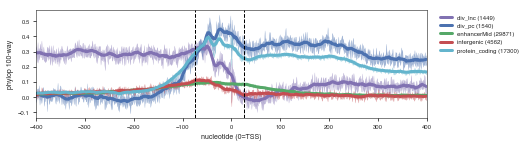

In [13]:
fig = plt.figure(figsize=(7,2))

lower = -400
upper = 400

for b in biotypes:
    df = data[(data["type"] == b) & (data["ntd"] >= lower) & (data["ntd"] < upper)]
    x = signal.savgol_filter(df["mean"], 15, 1)
    plt.fill_between(df["ntd"], df["y1"], df["y2"], color=palette[b], alpha=0.5)
    plt.plot(df["ntd"], x, color=palette[b], linewidth=3, label="%s (%s)" % (b, df["num"].iloc[0]))
plt.xlim((lower, upper))
plt.axvline(x=-75, color="black", linestyle="dashed", linewidth=1)
plt.axvline(x=25, color="black", linestyle="dashed", linewidth=1)
plt.legend(ncol=1, loc=1, bbox_to_anchor=(1.25, 1))
plt.xlabel("nucleotide (0=TSS)")
plt.ylabel("phylop 100-way")

In [14]:
order = ["enhancerMid", "intergenic", "div_lnc", "protein_coding", "div_pc"]

In [15]:
data["log_mean"] = np.log(data["mean"]+1)
data.head()

,idx,mean,ste,type,num,ntd,y1,y2,log_mean
0,0,0.171748,0.024772,div_lnc,1449,-1000,0.146977,0.196520,0.158497
1,1,0.136337,0.025702,div_lnc,1449,-999,0.110636,0.162039,0.127810
2,2,0.152647,0.025530,div_lnc,1449,-998,0.127117,0.178177,0.142061
3,3,0.134112,0.025126,div_lnc,1449,-997,0.108985,0.159238,0.125850
4,4,0.191071,0.024949,div_lnc,1449,-996,0.166122,0.216020,0.174853


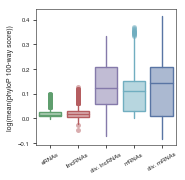

In [16]:
plt.figure(figsize=(2.5, 2.5))
ax = sns.boxplot(data=data, x="type", y="log_mean", order=order, palette=palette,
                 flierprops=dict(marker='o', markersize=5))
ax.set_xticklabels(["eRNAs", "lincRNAs", "div. lncRNAs", "mRNAs", "div. mRNAs"], rotation=30)
mimic_r_boxplot(ax)
ax.set_ylabel("log(mean(phyloP 100-way score))")
ax.set_xlabel("")

# directionality preference

## 1. import data

In [17]:
index = pd.read_table(index_f, sep="\t")

In [18]:
index_elem = index[["element", "oligo_type", "unique_id", "dupe_info", "SNP", "seq_name"]]
index_elem = index_elem.drop_duplicates()

In [19]:
hepg2_activ = pd.read_table(hepg2_activ_f, sep="\t")
hela_activ = pd.read_table(hela_activ_f, sep="\t")
k562_activ = pd.read_table(k562_activ_f, sep="\t")

In [20]:
hepg2_reps = [x for x in hepg2_activ.columns if "rna" in x]
hela_reps = [x for x in hela_activ.columns if "rna" in x]
k562_reps = [x for x in k562_activ.columns if "rna" in x]

In [21]:
annot = pd.read_table(annot_f, sep="\t")
annot.head()

,seqID,PromType2
0,WILDTYPE__Antisense.noflip.NA__chr1:100435456....,div_lnc
1,WILDTYPE__Lincrna.flip.sense__chr1:100731637.....,div_lnc
2,FLIPPED__Lincrna.flip.antisense__chr1:10073163...,div_lnc
3,FLIPPED__mrna.flip.antisense__chr1:100731714.....,div_pc
4,WILDTYPE__mrna.flip.sense__chr1:100731714..100...,div_pc


## 2. find mean activ per barcode and merge info

In [22]:
hepg2_cols = ["barcode"] + ["hepg2_%s" % x for x in hepg2_reps]
k562_cols = ["barcode"] + ["k562_%s" % x for x in k562_reps]
hela_cols = ["barcode"] + ["hela_%s" % x for x in hela_reps]
hela_cols

['barcode', 'hela_rna_1', 'hela_rna_2', 'hela_rna_3', 'hela_rna_4']

In [23]:
hepg2_activ.columns = hepg2_cols
k562_activ.columns = k562_cols
hela_activ.columns = hela_cols
hela_activ.head()

,barcode,hela_rna_1,hela_rna_2,hela_rna_3,hela_rna_4
0,AAAACAAAGTC,-0.839231,NaN,-4.842099,NaN
1,AAAACAAAGTT,NaN,NaN,NaN,NaN
2,AAAACAAATGT,-2.198951,-0.945005,-2.426499,NaN
3,AAAACAACGTC,NaN,NaN,NaN,0.764346
4,AAAACAACGTG,NaN,NaN,NaN,3.523603


In [24]:
data = index.merge(hepg2_activ[hepg2_cols], on="barcode").merge(hela_activ[hela_cols], on="barcode").merge(k562_activ[k562_cols], on="barcode")
data.sample(5)

,full_oligo,oligo_type,oligo_id,dupe_info,seq_name,tile_name,chr,locus_start,locus_end,strand,...,hepg2_rna_13,hepg2_rna_14,hela_rna_1,hela_rna_2,hela_rna_3,hela_rna_4,k562_rna_1,k562_rna_2,k562_rna_3,k562_rna_4
36131,ACTGGCCGCTTCACTGGGGCAGGAGCCCCGCAGGAGCCAGGTGTCT...,WILDTYPE_SNP_INDIV,919.1.2.0.20,none,"Lincrna.noflip.NA__chr9:98189077..98189191,-","Lincrna.noflip.NA__chr9:98189077..98189191,-,9...",chr9,98189077.0,98189191.0,-,...,-1.913760,-0.805666,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43437,ACTGGCCGCTTCACTGCCCCCGCCCCCCCGCCTTCTCCCCACGCGC...,WILDTYPE_SNP_INDIV,1138.1.1.0.9,none,"mrna.flip.sense__chr1:24104828..24104942,+","mrna.flip.sense__chr1:24104828..24104942,+,1138.1",chr1,24104828.0,24104942.0,+,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119803,ACTGGCCGCTTCACTGGCTTCGGACCGATCTCACAAGAAGCCTGGC...,RANDOM,1393.1,NaN,random_sequence,random_sequence,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13901,ACTGGCCGCTTCACTGGAATCATTCATCTCTCAGCTGTTGCAAGCT...,WILDTYPE,352.1.0.0.15,none,"Lincrna.flip.sense__chr17:14277348..14277462,+","Lincrna.flip.sense__chr17:14277348..14277462,+...",chr17,14277348.0,14277462.0,+,...,0.997370,0.297396,-2.360957,-5.854237,-5.694183,-5.454733,NaN,0.347341,-0.494494,-3.602878
15823,ACTGGCCGCTTCACTGAGCTGCGCTTGAGCCCGCCTTCCTGCCCAC...,WILDTYPE_SNP_INDIV,386.1.2.0.18,none,"Antisense.flip.sense__chr19:54960184..54960298,-",Antisense.flip.sense__chr19:54960184..54960298...,chr19,54960184.0,54960298.0,-,...,2.205551,2.691020,NaN,NaN,NaN,NaN,-0.259195,1.581368,3.336840,2.327094


## 3. make map of flipped to not flipped

In [25]:
index_elem["cage_id"] = index_elem.apply(get_cage_id, axis=1)
index_elem.sample(5)

,element,oligo_type,unique_id,dupe_info,SNP,seq_name,cage_id
10539,GCATTGCAGCAGAATGCGCTGACGTCAGAGACCACCCCTTCTGCGC...,WILDTYPE,WILDTYPE__Antisense.noflip.NA__chr14:101292375...,none,none,"Antisense.noflip.NA__chr14:101292375..101292489,+",chr14:101292375..101292489
97761,CTCTCGCATTGCTAATGCCTGTCCGTGACCTTTTAGGCTGATGCTG...,WILDTYPE,WILDTYPE__Enhancer.noflip.NA__chr8:62679813..6...,none,none,"Enhancer.noflip.NA__chr8:62679813..62679927,-",chr8:62679813..62679927
55176,GAGGCTCGGTCCCACTGCTCCCTGCACCGCGTAAGTATCTTCTTCT...,WILDTYPE_BUT_HAS_SNP,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__chr1:214...,none,none,"mrna.noflip.NA__chr1:214161796..214161910,+",chr1:214161796..214161910
53945,GGCGGGCGCTTCCCGGGGCTGCGGCGGGGCGGAGCTCGCGGAGGAA...,WILDTYPE_BUT_HAS_SNP,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__chr10:59...,none,none,"mrna.noflip.NA__chr10:5932135..5932249,+",chr10:5932135..5932249
49003,TGGCCAGCCGAGACCCCGCCCCCAACCCCCCTGCTGGGCCGGGTAG...,WILDTYPE_SNP_PLUS_HAPLO,WILDTYPE_SNP_PLUS_HAPLO__mrna.noflip.NA__chr1:...,none,"rs41311209,rs3790583","mrna.noflip.NA__chr1:45956777..45956891,-",chr1:45956777..45956891


In [26]:
flip_map = {}
for cage_id in list(index_elem["cage_id"].unique()):
    if cage_id == "none":
        continue
    unique_seqs = index_elem[index_elem["cage_id"] == cage_id].seq_name.unique()
    if len(unique_seqs) == 1:
        continue
    else:
        flip_map[unique_seqs[0]] = unique_seqs[1]

## 4. calculate differences b/w flipped and not flipped
require at least 10 barcodes in each

In [27]:
hepg2_results = {}
hela_results = {}
k562_results = {}

for sense in flip_map.keys():
    antisense = flip_map[sense]
    
    for results_dict, reps in zip([hepg2_results, k562_results, hela_results], [hepg2_cols, k562_cols, hela_cols]):
        rep_results = {"antisense": antisense}
        for rep in reps:
            if rep == "barcode":
                continue

            # extract sense/antisense barcode values for each cell type
            sense_vals = data[(data["seq_name"] == sense) & 
                              (data["oligo_type"].isin(["WILDTYPE", "WILDTYPE_BUT_HAS_SNP"]))][rep]
            antisense_vals = data[(data["seq_name"] == antisense) & 
                                  (data["oligo_type"].isin(["FLIPPED"]))][rep]
            
            # get non-nan values
            sense_vals = np.asarray(sense_vals)
            antisense_vals = np.asarray(antisense_vals)
            sense_nonan_vals = sense_vals[~np.isnan(sense_vals)]
            antisense_nonan_vals = antisense_vals[~np.isnan(antisense_vals)]

            # find "log2fc" for antisense/sense (as diff b/w medians)
            sense_median = np.nanmedian(sense_nonan_vals)
            antisense_median = np.nanmedian(antisense_nonan_vals)
            l2fc = antisense_median - sense_median

            # perform wilcoxon rank sum test
            if len(sense_nonan_vals) >= 10 and len(antisense_nonan_vals) >= 10:
                u, pval = stats.mannwhitneyu(sense_nonan_vals, antisense_nonan_vals, alternative="two-sided", use_continuity=False)
            else:
                u, pval = "NA__not_enough_barcodes", "NA__not_enough_barcodes"
                
            tmp = {"%s_l2fc" % rep: l2fc, "%s_pval" % rep: pval}
            rep_results.update(tmp)
        # add results to dicts
        results_dict[sense] = rep_results

In [28]:
hepg2_results = pd.DataFrame.from_dict(data=hepg2_results, orient="index").reset_index()
hela_results = pd.DataFrame.from_dict(data=hela_results, orient="index").reset_index()
k562_results = pd.DataFrame.from_dict(data=k562_results, orient="index").reset_index()

hepg2_results.head()

,index,antisense,hepg2_rna_3_l2fc,hepg2_rna_3_pval,hepg2_rna_4_l2fc,hepg2_rna_4_pval,hepg2_rna_5_l2fc,hepg2_rna_5_pval,hepg2_rna_6_l2fc,hepg2_rna_6_pval,...,hepg2_rna_10_l2fc,hepg2_rna_10_pval,hepg2_rna_11_l2fc,hepg2_rna_11_pval,hepg2_rna_12_l2fc,hepg2_rna_12_pval,hepg2_rna_13_l2fc,hepg2_rna_13_pval,hepg2_rna_14_l2fc,hepg2_rna_14_pval
0,"Antisense.flip.sense__chr10:11936664..11936778,-",Antisense.flip.antisense__chr10:11936664..1193...,-0.955036,7.18681e-06,-0.922778,0.00014462,-1.105758,0.000284896,-1.066156,0.000107203,...,-0.974395,1.42805e-05,-1.047575,1.55345e-05,-0.881599,2.47663e-05,-1.086131,5.0087e-07,-0.963772,2.65028e-05
1,Antisense.flip.sense__chr10:127408027..1274081...,Antisense.flip.antisense__chr10:127408027..127...,0.420771,0.00681192,0.574581,0.00882876,0.369642,0.0667981,0.191904,0.484991,...,0.396045,0.0808556,0.295536,0.406975,0.726125,0.0145238,0.333201,0.336975,0.411170,0.0163773
2,"Antisense.flip.sense__chr10:28821597..28821711,-",Antisense.flip.antisense__chr10:28821597..2882...,NaN,NA__not_enough_barcodes,NaN,NA__not_enough_barcodes,-2.147841,NA__not_enough_barcodes,NaN,NA__not_enough_barcodes,...,0.820121,NA__not_enough_barcodes,2.994781,NA__not_enough_barcodes,-0.105109,NA__not_enough_barcodes,NaN,NA__not_enough_barcodes,0.055433,NA__not_enough_barcodes
3,"Antisense.flip.sense__chr10:29698406..29698520,+",Antisense.flip.antisense__chr10:29698406..2969...,0.871655,0.0173854,0.689930,0.00935505,0.610245,0.0211892,0.521832,0.0256782,...,0.661749,0.220256,0.524992,0.025235,0.778664,0.0451276,0.699071,0.00898293,0.560720,0.0110092
4,"Antisense.flip.sense__chr10:31607957..31608071,-",Antisense.flip.antisense__chr10:31607957..3160...,-0.249732,0.0120929,-0.266292,0.191362,-0.269691,0.271694,-0.386411,0.110287,...,-0.405949,0.191362,-0.069855,0.044253,-0.072619,0.350688,-0.308173,0.237156,-0.402127,0.49373


## 5. combine and correct p-vals

In [29]:
hepg2_pvals = [x for x in hepg2_results.columns if "_pval" in x and "combined" not in x]
hela_pvals = [x for x in hela_results.columns if "_pval" in x and "combined" not in x]
k562_pvals = [x for x in k562_results.columns if "_pval" in x and "combined" not in x]

hepg2_results["hepg2_combined_pval"] = hepg2_results.apply(combine_pvals, reps=hepg2_pvals, axis=1)
hela_results["hela_combined_pval"] = hela_results.apply(combine_pvals, reps=hela_pvals, axis=1)
k562_results["k562_combined_pval"] = k562_results.apply(combine_pvals, reps=k562_pvals, axis=1)
k562_results.head()

,index,antisense,k562_rna_1_l2fc,k562_rna_1_pval,k562_rna_2_l2fc,k562_rna_2_pval,k562_rna_3_l2fc,k562_rna_3_pval,k562_rna_4_l2fc,k562_rna_4_pval,k562_combined_pval
0,"Antisense.flip.sense__chr10:11936664..11936778,-",Antisense.flip.antisense__chr10:11936664..1193...,-0.563539,0.0558003,-1.413510,5.08973e-05,-1.877181,2.17986e-07,-1.833037,0.000223078,1.105323e-12
1,Antisense.flip.sense__chr10:127408027..1274081...,Antisense.flip.antisense__chr10:127408027..127...,0.309298,0.359397,0.529596,0.116143,0.266319,0.106351,0.244407,0.0548178,1.389349e-02
2,"Antisense.flip.sense__chr10:28821597..28821711,-",Antisense.flip.antisense__chr10:28821597..2882...,NaN,NA__not_enough_barcodes,0.948360,NA__not_enough_barcodes,NaN,NA__not_enough_barcodes,NaN,NA__not_enough_barcodes,NaN
3,"Antisense.flip.sense__chr10:29698406..29698520,+",Antisense.flip.antisense__chr10:29698406..2969...,-0.254258,0.699028,0.348291,0.185531,0.463986,0.0185253,0.494660,0.065851,2.369739e-02
4,"Antisense.flip.sense__chr10:31607957..31608071,-",Antisense.flip.antisense__chr10:31607957..3160...,-0.391520,0.2217,-0.117235,0.0326696,-0.523093,0.0537644,-0.959827,0.00345432,2.700817e-04


In [30]:
hepg2_reps = [x for x in hepg2_activ.columns if "rna" in x]
hela_reps = [x for x in hela_activ.columns if "rna" in x]
k562_reps = [x for x in k562_activ.columns if "rna" in x]

In [31]:
all_dfs = []
for df, reps, cell in zip([hepg2_results, hela_results, k562_results], [hepg2_reps, hela_reps, k562_reps], ["hepg2", "hela", "k562"]):
    reps.extend(["%s_combined" % cell])
    print(cell)
    for rep in reps:
        print(rep)
        col = "%s_pval" % rep
        sub_df = df[~(df[col].astype(str).str.contains("NA")) & ~(pd.isnull(df[col]))][["index", "antisense", col]]

        new_pvals = multicomp.multipletests(sub_df[col], method="bonferroni")[1]
        sub_df["%s_padj" % (rep)] = new_pvals
        sub_df.drop(col, axis=1, inplace=True)

        df = df.merge(sub_df, on=["index", "antisense"], how="left")
    all_dfs.append(df)

hepg2
hepg2_rna_3
hepg2_rna_4
hepg2_rna_5
hepg2_rna_6
hepg2_rna_7
hepg2_rna_8
hepg2_rna_9
hepg2_rna_10
hepg2_rna_11
hepg2_rna_12
hepg2_rna_13
hepg2_rna_14
hepg2_combined
hela
hela_rna_1
hela_rna_2
hela_rna_3
hela_rna_4
hela_combined
k562
k562_rna_1
k562_rna_2
k562_rna_3
k562_rna_4
k562_combined


In [32]:
for cell, df in zip(["hepg2", "hela", "k562"], all_dfs):
    print(cell)
    l2fc_cols = [x for x in df.columns if "_l2fc" in x and "combined" not in x]
    print(l2fc_cols)
    comb_col = "%s_combined_padj" % (cell)
    print(comb_col)
    df["%s_sig" % cell] = df.apply(is_sig_combined, col=comb_col, thresh=0.05, l2fc_cols=l2fc_cols, axis=1)

hepg2
['hepg2_rna_3_l2fc', 'hepg2_rna_4_l2fc', 'hepg2_rna_5_l2fc', 'hepg2_rna_6_l2fc', 'hepg2_rna_7_l2fc', 'hepg2_rna_8_l2fc', 'hepg2_rna_9_l2fc', 'hepg2_rna_10_l2fc', 'hepg2_rna_11_l2fc', 'hepg2_rna_12_l2fc', 'hepg2_rna_13_l2fc', 'hepg2_rna_14_l2fc']
hepg2_combined_padj
hela
['hela_rna_1_l2fc', 'hela_rna_2_l2fc', 'hela_rna_3_l2fc', 'hela_rna_4_l2fc']
hela_combined_padj
k562
['k562_rna_1_l2fc', 'k562_rna_2_l2fc', 'k562_rna_3_l2fc', 'k562_rna_4_l2fc']
k562_combined_padj


## 6. put it all in 1 dataframe

In [33]:
all_results = all_dfs[0].merge(all_dfs[1], on=["index", "antisense"], how="outer").merge(all_dfs[2], on=["index", "antisense"], how="outer")
all_results.head()

,index,antisense,hepg2_rna_3_l2fc,hepg2_rna_3_pval,hepg2_rna_4_l2fc,hepg2_rna_4_pval,hepg2_rna_5_l2fc,hepg2_rna_5_pval,hepg2_rna_6_l2fc,hepg2_rna_6_pval,...,k562_rna_3_pval,k562_rna_4_l2fc,k562_rna_4_pval,k562_combined_pval,k562_rna_1_padj,k562_rna_2_padj,k562_rna_3_padj,k562_rna_4_padj,k562_combined_padj,k562_sig
0,"Antisense.flip.sense__chr10:11936664..11936778,-",Antisense.flip.antisense__chr10:11936664..1193...,-0.955036,7.18681e-06,-0.922778,0.00014462,-1.105758,0.000284896,-1.066156,0.000107203,...,2.17986e-07,-1.833037,0.000223078,1.105323e-12,1,0.0160327,7.76031e-05,0.0640234,3.548087e-10,sig
1,Antisense.flip.sense__chr10:127408027..1274081...,Antisense.flip.antisense__chr10:127408027..127...,0.420771,0.00681192,0.574581,0.00882876,0.369642,0.0667981,0.191904,0.484991,...,0.106351,0.244407,0.0548178,1.389349e-02,1,1,1,1,1.000000e+00,not sig
2,"Antisense.flip.sense__chr10:28821597..28821711,-",Antisense.flip.antisense__chr10:28821597..2882...,NaN,NA__not_enough_barcodes,NaN,NA__not_enough_barcodes,-2.147841,NA__not_enough_barcodes,NaN,NA__not_enough_barcodes,...,NA__not_enough_barcodes,NaN,NA__not_enough_barcodes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Antisense.flip.sense__chr10:29698406..29698520,+",Antisense.flip.antisense__chr10:29698406..2969...,0.871655,0.0173854,0.689930,0.00935505,0.610245,0.0211892,0.521832,0.0256782,...,0.0185253,0.494660,0.065851,2.369739e-02,1,1,1,1,1.000000e+00,not sig
4,"Antisense.flip.sense__chr10:31607957..31608071,-",Antisense.flip.antisense__chr10:31607957..3160...,-0.249732,0.0120929,-0.266292,0.191362,-0.269691,0.271694,-0.386411,0.110287,...,0.0537644,-0.959827,0.00345432,2.700817e-04,1,1,1,0.991389,8.669623e-02,not sig


In [34]:
all_results["padj_in_one"] = all_results.apply(padj_in_one, axis=1)
all_results.sample(5)

,index,antisense,hepg2_rna_3_l2fc,hepg2_rna_3_pval,hepg2_rna_4_l2fc,hepg2_rna_4_pval,hepg2_rna_5_l2fc,hepg2_rna_5_pval,hepg2_rna_6_l2fc,hepg2_rna_6_pval,...,k562_rna_4_l2fc,k562_rna_4_pval,k562_combined_pval,k562_rna_1_padj,k562_rna_2_padj,k562_rna_3_padj,k562_rna_4_padj,k562_combined_padj,k562_sig,padj_in_one
376,"mrna.flip.sense__chr10:38146503..38146617,-","mrna.flip.antisense__chr10:38146503..38146617,+",0.829819,0.003487,0.398811,0.0496842,0.518389,0.00661176,0.493858,0.0645208,...,0.131537,0.698038,0.956124,1,1,1,1,1.000000,not sig,True
518,"mrna.flip.sense__chr6:153304679..153304793,-","mrna.flip.antisense__chr6:153304679..153304793,+",-0.662908,0.032799,-1.287767,0.00171225,-0.979891,0.006498,-0.684077,0.0116126,...,-0.603682,0.278698,0.000428,1,1,1,1,0.137343,not sig,True
268,"Enhancer.flip.sense__chr7:111724723..111724837,+",Enhancer.flip.antisense__chr7:111724723..11172...,0.444733,0.395158,0.462266,0.309528,0.279978,0.116143,0.349156,0.119844,...,0.807122,NA__not_enough_barcodes,0.045295,NaN,1,1,NaN,1.000000,not sig,True
504,"mrna.flip.sense__chr5:149380182..149380296,-","mrna.flip.antisense__chr5:149380182..149380296,+",2.985533,NA__not_enough_barcodes,0.421675,NA__not_enough_barcodes,2.100672,NA__not_enough_barcodes,-0.197365,NA__not_enough_barcodes,...,1.766333,NA__not_enough_barcodes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
77,"Antisense.flip.sense__chr22:28315407..28315521,+",Antisense.flip.antisense__chr22:28315407..2831...,-0.012235,0.902436,-0.369626,0.315302,-0.089645,0.945415,0.142240,0.504235,...,-0.488636,0.181721,0.001499,1,1,1,1,0.481041,not sig,True


## 7. find out how many are significantly different in at least 1 cell type

In [35]:
annot["sense"] = annot["seqID"].str.split("__", expand=True)[1] + "__" + annot["seqID"].str.split("__", expand=True)[2]
annot_wt = annot[~(annot["seqID"].str.contains("SNP_INDIV")) & ~(annot["seqID"].str.contains("HAPLO")) & ~(annot["seqID"].str.contains("SCRAMBLED"))]
annot_wt.head()

,seqID,PromType2,sense
0,WILDTYPE__Antisense.noflip.NA__chr1:100435456....,div_lnc,"Antisense.noflip.NA__chr1:100435456..100435570,-"
1,WILDTYPE__Lincrna.flip.sense__chr1:100731637.....,div_lnc,"Lincrna.flip.sense__chr1:100731637..100731751,-"
2,FLIPPED__Lincrna.flip.antisense__chr1:10073163...,div_lnc,Lincrna.flip.antisense__chr1:100731637..100731...
3,FLIPPED__mrna.flip.antisense__chr1:100731714.....,div_pc,"mrna.flip.antisense__chr1:100731714..100731828,-"
4,WILDTYPE__mrna.flip.sense__chr1:100731714..100...,div_pc,"mrna.flip.sense__chr1:100731714..100731828,+"


In [36]:
all_results.head()

,index,antisense,hepg2_rna_3_l2fc,hepg2_rna_3_pval,hepg2_rna_4_l2fc,hepg2_rna_4_pval,hepg2_rna_5_l2fc,hepg2_rna_5_pval,hepg2_rna_6_l2fc,hepg2_rna_6_pval,...,k562_rna_4_l2fc,k562_rna_4_pval,k562_combined_pval,k562_rna_1_padj,k562_rna_2_padj,k562_rna_3_padj,k562_rna_4_padj,k562_combined_padj,k562_sig,padj_in_one
0,"Antisense.flip.sense__chr10:11936664..11936778,-",Antisense.flip.antisense__chr10:11936664..1193...,-0.955036,7.18681e-06,-0.922778,0.00014462,-1.105758,0.000284896,-1.066156,0.000107203,...,-1.833037,0.000223078,1.105323e-12,1,0.0160327,7.76031e-05,0.0640234,3.548087e-10,sig,True
1,Antisense.flip.sense__chr10:127408027..1274081...,Antisense.flip.antisense__chr10:127408027..127...,0.420771,0.00681192,0.574581,0.00882876,0.369642,0.0667981,0.191904,0.484991,...,0.244407,0.0548178,1.389349e-02,1,1,1,1,1.000000e+00,not sig,True
2,"Antisense.flip.sense__chr10:28821597..28821711,-",Antisense.flip.antisense__chr10:28821597..2882...,NaN,NA__not_enough_barcodes,NaN,NA__not_enough_barcodes,-2.147841,NA__not_enough_barcodes,NaN,NA__not_enough_barcodes,...,NaN,NA__not_enough_barcodes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,"Antisense.flip.sense__chr10:29698406..29698520,+",Antisense.flip.antisense__chr10:29698406..2969...,0.871655,0.0173854,0.689930,0.00935505,0.610245,0.0211892,0.521832,0.0256782,...,0.494660,0.065851,2.369739e-02,1,1,1,1,1.000000e+00,not sig,True
4,"Antisense.flip.sense__chr10:31607957..31608071,-",Antisense.flip.antisense__chr10:31607957..3160...,-0.249732,0.0120929,-0.266292,0.191362,-0.269691,0.271694,-0.386411,0.110287,...,-0.959827,0.00345432,2.700817e-04,1,1,1,0.991389,8.669623e-02,not sig,True


In [37]:
sig_results = all_results[all_results["padj_in_one"]]
sig_results = sig_results.merge(annot_wt, left_on="index", right_on="sense", how="left")
sig_results.head()

,index,antisense,hepg2_rna_3_l2fc,hepg2_rna_3_pval,hepg2_rna_4_l2fc,hepg2_rna_4_pval,hepg2_rna_5_l2fc,hepg2_rna_5_pval,hepg2_rna_6_l2fc,hepg2_rna_6_pval,...,k562_rna_1_padj,k562_rna_2_padj,k562_rna_3_padj,k562_rna_4_padj,k562_combined_padj,k562_sig,padj_in_one,seqID,PromType2,sense
0,"Antisense.flip.sense__chr10:11936664..11936778,-",Antisense.flip.antisense__chr10:11936664..1193...,-0.955036,7.18681e-06,-0.922778,0.00014462,-1.105758,0.000284896,-1.066156,0.000107203,...,1,0.0160327,7.76031e-05,0.0640234,3.548087e-10,sig,True,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,intergenic,"Antisense.flip.sense__chr10:11936664..11936778,-"
1,Antisense.flip.sense__chr10:127408027..1274081...,Antisense.flip.antisense__chr10:127408027..127...,0.420771,0.00681192,0.574581,0.00882876,0.369642,0.0667981,0.191904,0.484991,...,1,1,1,1,1.000000e+00,not sig,True,WILDTYPE__Antisense.flip.sense__chr10:12740802...,div_lnc,Antisense.flip.sense__chr10:127408027..1274081...
2,"Antisense.flip.sense__chr10:29698406..29698520,+",Antisense.flip.antisense__chr10:29698406..2969...,0.871655,0.0173854,0.689930,0.00935505,0.610245,0.0211892,0.521832,0.0256782,...,1,1,1,1,1.000000e+00,not sig,True,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,intergenic,"Antisense.flip.sense__chr10:29698406..29698520,+"
3,"Antisense.flip.sense__chr10:31607957..31608071,-",Antisense.flip.antisense__chr10:31607957..3160...,-0.249732,0.0120929,-0.266292,0.191362,-0.269691,0.271694,-0.386411,0.110287,...,1,1,1,0.991389,8.669623e-02,not sig,True,WILDTYPE__Antisense.flip.sense__chr10:31607957...,antisense,"Antisense.flip.sense__chr10:31607957..31608071,-"
4,"Antisense.flip.sense__chr10:38146597..38146711,+",Antisense.flip.antisense__chr10:38146597..3814...,-0.849603,0.00659137,-0.784698,0.00150835,-1.069601,0.0213333,-0.722076,0.0191032,...,1,1,0.938776,1,7.483794e-02,not sig,True,WILDTYPE__Antisense.flip.sense__chr10:38146597...,div_lnc,"Antisense.flip.sense__chr10:38146597..38146711,+"


In [38]:
sig_results["sig_in_any"] = sig_results.apply(sig_in_one, axis=1)
sig_results.head()

,index,antisense,hepg2_rna_3_l2fc,hepg2_rna_3_pval,hepg2_rna_4_l2fc,hepg2_rna_4_pval,hepg2_rna_5_l2fc,hepg2_rna_5_pval,hepg2_rna_6_l2fc,hepg2_rna_6_pval,...,k562_rna_2_padj,k562_rna_3_padj,k562_rna_4_padj,k562_combined_padj,k562_sig,padj_in_one,seqID,PromType2,sense,sig_in_any
0,"Antisense.flip.sense__chr10:11936664..11936778,-",Antisense.flip.antisense__chr10:11936664..1193...,-0.955036,7.18681e-06,-0.922778,0.00014462,-1.105758,0.000284896,-1.066156,0.000107203,...,0.0160327,7.76031e-05,0.0640234,3.548087e-10,sig,True,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,intergenic,"Antisense.flip.sense__chr10:11936664..11936778,-",True
1,Antisense.flip.sense__chr10:127408027..1274081...,Antisense.flip.antisense__chr10:127408027..127...,0.420771,0.00681192,0.574581,0.00882876,0.369642,0.0667981,0.191904,0.484991,...,1,1,1,1.000000e+00,not sig,True,WILDTYPE__Antisense.flip.sense__chr10:12740802...,div_lnc,Antisense.flip.sense__chr10:127408027..1274081...,True
2,"Antisense.flip.sense__chr10:29698406..29698520,+",Antisense.flip.antisense__chr10:29698406..2969...,0.871655,0.0173854,0.689930,0.00935505,0.610245,0.0211892,0.521832,0.0256782,...,1,1,1,1.000000e+00,not sig,True,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,intergenic,"Antisense.flip.sense__chr10:29698406..29698520,+",True
3,"Antisense.flip.sense__chr10:31607957..31608071,-",Antisense.flip.antisense__chr10:31607957..3160...,-0.249732,0.0120929,-0.266292,0.191362,-0.269691,0.271694,-0.386411,0.110287,...,1,1,0.991389,8.669623e-02,not sig,True,WILDTYPE__Antisense.flip.sense__chr10:31607957...,antisense,"Antisense.flip.sense__chr10:31607957..31608071,-",False
4,"Antisense.flip.sense__chr10:38146597..38146711,+",Antisense.flip.antisense__chr10:38146597..3814...,-0.849603,0.00659137,-0.784698,0.00150835,-1.069601,0.0213333,-0.722076,0.0191032,...,1,0.938776,1,7.483794e-02,not sig,True,WILDTYPE__Antisense.flip.sense__chr10:38146597...,div_lnc,"Antisense.flip.sense__chr10:38146597..38146711,+",True


In [39]:
sig_results.sig_in_any.value_counts()

True     248
False    153
Name: sig_in_any, dtype: int64

## 8. plot

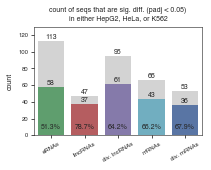

In [40]:
plt.figure(figsize=(3, 2))

ax = sns.countplot(data=sig_results, x="PromType2", color="lightgray", order=TSS_CLASS_ORDER)
sns.countplot(data=sig_results[sig_results["sig_in_any"]], x="PromType2", palette=TSS_CLASS_PALETTE, 
              order=TSS_CLASS_ORDER, ax=ax)
ax.set_xticklabels(["eRNAs", "lincRNAs", "div. lncRNAs", "mRNAs", "div. mRNAs"], rotation=30)

counts = []
tots = []
for i, p in enumerate(ax.patches):
    if i <= 4 :
        tots.append(p.get_height())
    else:
        counts.append(p.get_height())
    text = int(p.get_height())
    ax.annotate(text, (p.get_x() + p.get_width()/2., p.get_height()), 
                ha="center", va="bottom", size=fontsize)

for i in range(len(counts)):
    percent = (float(counts[i])/tots[i])*100
    text = "%.1f%%" % percent
    ax.annotate(text, (i, 5), ha="center", va="bottom", size=fontsize)

plt.xlabel("")
plt.ylim((0, 130))
plt.title("count of seqs that are sig. diff. (padj < 0.05)\nin either HepG2, HeLa, or K562")

## 9. remove tmp files

In [41]:
!rm tmp/*.txt
!rmdir tmp